<a href="https://colab.research.google.com/github/Hashhhhhhhh/Raman-modified-NLSE/blob/main/Raman_Modified_NLSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Time resolution: 0.98 fs
Time window: 1.0 ps
Initial peak power: 5000 W
Nonlinear length: 0.1538 m
Dispersion length: 0.1250 m
Propagating from 0.000 to 0.100 m
Step size: 0.001000 m, Total steps: 101


/tmp/ipython-input-1027030331.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  R_raman = R_raman / (np.trapz(R_raman, t_span) if np.trapz(R_raman, t_span) > 0 else 1)
/tmp/ipython-input-1027030331.py:74: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  raman_contribution[j] = np.trapz(integrand, t_span[:j+1])


Progress: 9.9%
Progress: 19.8%
Progress: 29.7%
Progress: 39.6%
Progress: 49.5%
Progress: 59.4%
Progress: 69.3%
Progress: 79.2%
Progress: 89.1%
Progress: 99.0%


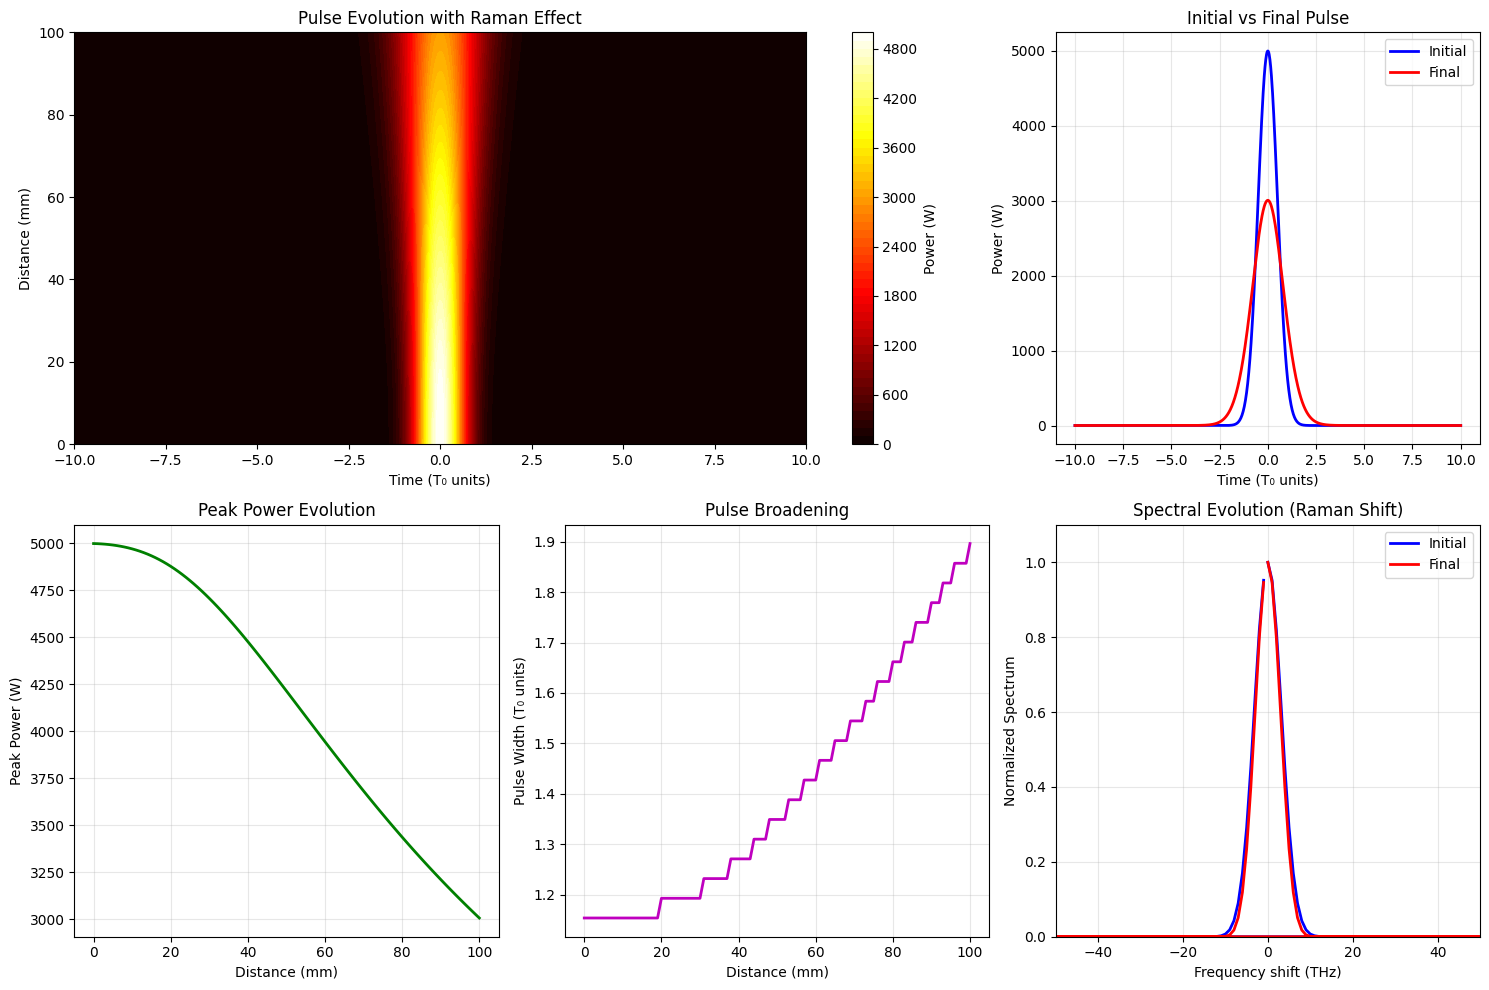

Propagation distance: 100.00 mm
Initial peak power: 4999.0 W
Final peak power: 3006.2 W
Power change: -39.9%
Initial pulse width: 1.15 T₀
Final pulse width: 1.90 T₀
Broadening factor: 1.64


In [4]:
def raman_response_function(t, tau1=12.2e-15, tau2=32e-15):
    """
    Raman response function R(t) for silica fiber
    """
    t = np.asarray(t)
    result = np.zeros_like(t)
    mask = t > 0
    result[mask] = ((tau1**2 + tau2**2) / (tau1 * tau2**2) *
                    np.exp(-t[mask]/tau2) * np.sin(t[mask]/tau1))
    return result

def solve_raman_nlse_improved(A0, z_span, t_span, beta2, gamma, alpha, fr=0.18, dz=None):
    """
    Improved solver for Raman-modified NLSE
    """
    # Grid
    dt = t_span[1] - t_span[0]
    N = len(t_span)

    # Adaptive step size based on nonlinearity
    if dz is None:
        P0 = np.max(np.abs(A0)**2)
        dz = min(0.001, 1/(gamma * P0 * 10))  # Conservative step size

    z_points = np.arange(z_span[0], z_span[1] + dz, dz)

    # Frequency domain
    omega = 2 * np.pi * fftfreq(N, dt)

    # field initialization
    A = A0.copy().astype(complex)

    #Raman response
    R_raman = raman_response_function(t_span)
    R_raman = R_raman / (np.trapz(R_raman, t_span) if np.trapz(R_raman, t_span) > 0 else 1)


    save_every = max(1, len(z_points) // 100)
    saved_indices = range(0, len(z_points), save_every)
    A_evolution = np.zeros((len(saved_indices), len(A0)), dtype=complex)
    saved_z = []
    save_idx = 0

    #initial condition
    A_evolution[0] = A0
    saved_z.append(z_points[0])
    save_idx = 1

    print(f"Propagating from {z_span[0]:.3f} to {z_span[1]:.3f} m")
    print(f"Step size: {dz:.6f} m, Total steps: {len(z_points)}")

    for i, z in enumerate(z_points[1:], 1):
        if i % (len(z_points) // 10) == 0:
            print(f"Progress: {100*i/len(z_points):.1f}%")

        # Split-step method: Linear step (half)
        A_freq = fft(A)
        linear_phase = 1j * beta2 * omega**2 * dz / 4 - alpha * dz / 2
        A_freq *= np.exp(linear_phase)
        A = ifft(A_freq)

        # Nonlinear step
        intensity = np.abs(A)**2

        # Instantaneous Kerr response
        kerr_contribution = (1 - fr) * intensity

        # Delayed Raman response (convolution in time domain)
        raman_contribution = np.zeros_like(intensity)
        for j in range(len(t_span)):
            if j > 0:  # Only for t > 0
                # Trapezoidal integration for convolution
                integrand = R_raman[:j+1] * intensity[:j+1][::-1]
                raman_contribution[j] = np.trapz(integrand, t_span[:j+1])

        raman_contribution *= fr

        # Total nonlinear phase shift
        nonlinear_phase = 1j * gamma * (kerr_contribution + raman_contribution) * dz

        # Apply nonlinear operator
        A *= np.exp(nonlinear_phase)

        # Linear step (second half)
        A_freq = fft(A)
        A_freq *= np.exp(linear_phase)
        A = ifft(A_freq)

        if i in saved_indices and save_idx < len(A_evolution):
            A_evolution[save_idx] = A
            saved_z.append(z)
            save_idx += 1

    return np.array(saved_z), A_evolution[:save_idx]

def analyze_pulse_properties(t, A_evolution, z_points):
    """
    Analyze pulse properties during propagation
    """
    powers = np.abs(A_evolution)**2
    peak_powers = np.max(powers, axis=1)

    #pulse widths (FWHM)
    pulse_widths = []
    for i in range(len(z_points)):
        power = powers[i]
        peak_power = np.max(power)
        half_max_indices = np.where(power >= peak_power/2)[0]
        if len(half_max_indices) > 1:
            width = t[half_max_indices[-1]] - t[half_max_indices[0]]
            pulse_widths.append(width)
        else:
            pulse_widths.append(0)

    return peak_powers, np.array(pulse_widths)

if __name__ == "__main__":
    # Pulse parameters - higher power for stronger nonlinearity
    T0 = 50e-15    # 50 fs pulse (shorter for stronger effects)
    P0 = 5000      # 5 kW peak power (higher for nonlinear effects)

    # Fiber parameters
    beta2 = -2e-26     # s²/m (anomalous dispersion at 1550 nm)
    gamma = 1.3e-3     # 1/(W·m) (typical nonlinear coefficient)
    alpha = 0.046      # Loss coefficient (0.2 dB/km)
    fr = 0.18          # Raman fraction for silica


    t_window = 20 * T0
    N_t = 1024         # Fewer points for stability
    t = np.linspace(-t_window/2, t_window/2, N_t)
    dt = t[1] - t[0]

    print(f"Time resolution: {dt*1e15:.2f} fs")
    print(f"Time window: {t_window*1e12:.1f} ps")

    # Initial Gaussian pulse
    A0 = np.sqrt(P0) * np.exp(-(t/(T0))**2)

    # Propagation distance (longer to see raman effect)
    z_span = (0, 0.1)

    print(f"Initial peak power: {P0} W")
    print(f"Nonlinear length: {1/(gamma*P0):.4f} m")
    print(f"Dispersion length: {T0**2/np.abs(beta2):.4f} m")

    z_points, A_evolution = solve_raman_nlse_improved(A0, z_span, t, beta2, gamma, alpha, fr)


    peak_powers, pulse_widths = analyze_pulse_properties(t, A_evolution, z_points)

    fig = plt.figure(figsize=(15, 10))

    #Pulse evolution contour plot
    ax1 = plt.subplot(2, 3, (1, 2))
    power_evolution = np.abs(A_evolution)**2
    contour = ax1.contourf(t/T0, z_points*1000, power_evolution, levels=50, cmap='hot')
    ax1.set_xlabel('Time (T₀ units)')
    ax1.set_ylabel('Distance (mm)')
    ax1.set_title('Pulse Evolution with Raman Effect')
    plt.colorbar(contour, ax=ax1, label='Power (W)')

    #Initial vs final comparison
    ax2 = plt.subplot(2, 3, 3)
    ax2.plot(t/T0, np.abs(A0)**2, 'b-', label='Initial', linewidth=2)
    ax2.plot(t/T0, np.abs(A_evolution[-1])**2, 'r-', label='Final', linewidth=2)
    ax2.set_xlabel('Time (T₀ units)')
    ax2.set_ylabel('Power (W)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_title('Initial vs Final Pulse')

    #Peak power evolution
    ax3 = plt.subplot(2, 3, 4)
    ax3.plot(z_points*1000, peak_powers, 'g-', linewidth=2)
    ax3.set_xlabel('Distance (mm)')
    ax3.set_ylabel('Peak Power (W)')
    ax3.grid(True, alpha=0.3)
    ax3.set_title('Peak Power Evolution')

    #Pulse width evolution
    ax4 = plt.subplot(2, 3, 5)
    ax4.plot(z_points*1000, pulse_widths/T0, 'm-', linewidth=2)
    ax4.set_xlabel('Distance (mm)')
    ax4.set_ylabel('Pulse Width (T₀ units)')
    ax4.grid(True, alpha=0.3)
    ax4.set_title('Pulse Broadening')

    # 5. Spectrum evolution
    ax5 = plt.subplot(2, 3, 6)
    # spectra calculation
    freq = fftfreq(len(t), dt)
    spectrum_initial = np.abs(fft(A0))**2
    spectrum_final = np.abs(fft(A_evolution[-1]))**2

    # Convert to frequency shift
    freq_shift_THz = freq / 1e12  # Convert to THz

    ax5.plot(freq_shift_THz, spectrum_initial/np.max(spectrum_initial), 'b-', label='Initial', linewidth=2)
    ax5.plot(freq_shift_THz, spectrum_final/np.max(spectrum_final), 'r-', label='Final', linewidth=2)
    ax5.set_xlim(-50, 50)
    ax5.set_ylim(0, 1.1)
    ax5.set_xlabel('Frequency shift (THz)')
    ax5.set_ylabel('Normalized Spectrum')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    ax5.set_title('Spectral Evolution (Raman Shift)')

    plt.tight_layout()
    plt.show()

    print(f"Propagation distance: {z_points[-1]*1000:.2f} mm")
    print(f"Initial peak power: {peak_powers[0]:.1f} W")
    print(f"Final peak power: {peak_powers[-1]:.1f} W")
    print(f"Power change: {100*(peak_powers[-1]/peak_powers[0]-1):.1f}%")
    print(f"Initial pulse width: {pulse_widths[0]/T0:.2f} T₀")
    print(f"Final pulse width: {pulse_widths[-1]/T0:.2f} T₀")
    print(f"Broadening factor: {pulse_widths[-1]/pulse_widths[0]:.2f}")

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq